Setup and Imports

In [1]:
!pip install tensorflow keras matplotlib seaborn scikit-learn

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip "/content/drive/MyDrive/ML Project - Alzheimer Stage Prediction/Alzheimer_dataset.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (46).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (47).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (48).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (49).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (5).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (50).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (51).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (52).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (53).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (54).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (55).jpg  
  inflating: /content/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (

In [7]:
import os
import shutil

# --------------------------
# SET YOUR PATHS HERE
# --------------------------
SOURCE_DIR = "/content/Alzheimer_MRI_4_classes_dataset"
TARGET_DIR = "/content/Alzheimer_MRI_2_classes"

demented_folders = ["MildDemented", "ModerateDemented", "VeryMildDemented"]
non_demented_folder = "NonDemented"

# --------------------------
# CREATE TARGET STRUCTURE
# --------------------------
os.makedirs(os.path.join(TARGET_DIR, "Demented"), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, "NonDemented"), exist_ok=True)

# --------------------------
# COPY DEMENTED IMAGES
# --------------------------
count_demented = 0
for folder in demented_folders:
    src_path = os.path.join(SOURCE_DIR, folder)

    for filename in os.listdir(src_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            shutil.copy(
                os.path.join(src_path, filename),
                os.path.join(TARGET_DIR, "Demented", filename)
            )
            count_demented += 1

# --------------------------
# COPY NON-DEMENTED IMAGES
# --------------------------
count_non_demented = 0
src_path = os.path.join(SOURCE_DIR, non_demented_folder)

for filename in os.listdir(src_path):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        shutil.copy(
            os.path.join(src_path, filename),
            os.path.join(TARGET_DIR, "NonDemented", filename)
        )
        count_non_demented += 1

# --------------------------
# SUMMARY
# --------------------------
print("Merged Successfully!")
print(f"Demented images: {count_demented}")
print(f"Non-Demented images: {count_non_demented}")
print(f"New dataset location: {TARGET_DIR}")

Merged Successfully!
Demented images: 3200
Non-Demented images: 3200
New dataset location: /content/Alzheimer_MRI_2_classes


In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
import matplotlib.pyplot as plt
import pathlib
import shutil

In [9]:
DATA_DIR = "/content/Alzheimer_MRI_2_classes"
OUTPUT_DIR = "/content/vgg_binary_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
LR = 1e-4

# -------------------------
# DATA GENERATORS
# -------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.12,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = valid_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# Print class indices
print("Class indices:", train_gen.class_indices)

Found 4352 images belonging to 2 classes.
Found 1088 images belonging to 2 classes.
Class indices: {'Demented': 0, 'NonDemented': 1}


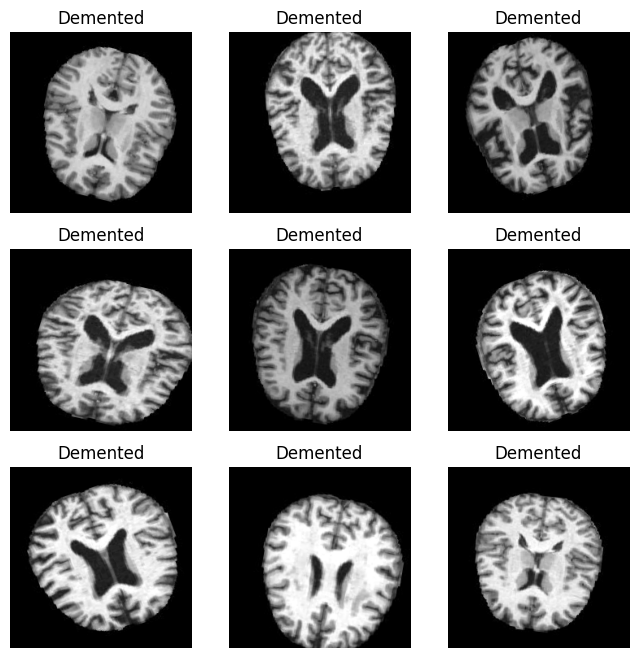

In [18]:
# Visualize a Few Samples
for imgs, labels in train_gen:
    plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(imgs[i])
        plt.title(list(train_gen.class_indices.keys())[np.argmax(labels[i])])
        plt.axis('off')
    break

In [10]:
# BUILD MODEL (VGG16 base + global pool)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Freeze base
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
# Binary output: single neuron with sigmoid
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,66

 Total params: 15,045,185 (57.39 MB)

 Trainable params: 329,473 (1.26 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [11]:
# CALLBACKS
checkpoint_path = os.path.join(OUTPUT_DIR, "vgg16_binary_best.h5")
csv_log_path = os.path.join(OUTPUT_DIR, "training_log.csv")

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    CSVLogger(csv_log_path)
]

In [12]:
# TRAIN STAGE 1: top layers only
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5874 - loss: 0.6884
Epoch 1: val_loss improved from inf to 0.68643, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 90s 533ms/step - accuracy: 0.5875 - loss: 0.6882 - val_accuracy: 0.5441 - val_loss: 0.6864 - learning_rate: 1.0000e-04
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6615 - loss: 0.6091
Epoch 2: val_loss improved from 0.68643 to 0.64264, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 93s 685ms/step - accuracy: 0.6614 - loss: 0.6092 - val_accuracy: 0.7022 - val_loss: 0.6426 - learning_rate: 1.0000e-04
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.6623 - loss: 0.5988
Epoch 3: val_loss improved from 0.64264 to 0.59100, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 69s 504ms/step - accuracy: 0.6623 - loss: 0.5987 - val_accuracy: 0.7206 - val_loss: 0.5910 - learning_rate: 1.0000e-04
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6711 - loss: 0.5932
Epoch 4: val_loss improved from 0.59100 to 0.55124, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 68s 500ms/step - accuracy: 0.6712 - loss: 0.5931 - val_accuracy: 0.7206 - val_loss: 0.5512 - learning_rate: 1.0000e-04
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6901 - loss: 0.5747
Epoch 5: val_loss improved from 0.55124 to 0.54352, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 78s 574ms/step - accuracy: 0.6902 - loss: 0.5746 - val_accuracy: 0.7114 - val_loss: 0.5435 - learning_rate: 1.0000e-04
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7061 - loss: 0.5472
Epoch 6: val_loss improved from 0.54352 to 0.53540, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 86s 635ms/step - accuracy: 0.7061 - loss: 0.5472 - val_accuracy: 0.7132 - val_loss: 0.5354 - learning_rate: 1.0000e-04
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7160 - loss: 0.5430
Epoch 7: val_loss did not improve from 0.53540
136/136 ━━━━━━━━━━━━━━━━━━━━ 71s 521ms/step - accuracy: 0.7160 - loss: 0.5429 - val_accuracy: 0.6838 - val_loss: 0.5500 - learning_rate: 1.0000e-04
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7289 - loss: 0.5048
Epoch 8: val_loss improved from 0.53540 to 0.51120, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 75s 555ms/step - accuracy: 0.7289 - loss: 0.5049 - val_accuracy: 0.7353 - val_loss: 0.5112 - learning_rate: 1.0000e-04
Epoch 9/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7429 - loss: 0.5012
Epoch 9: val_loss did not improve from 0.51120
136/136 ━━━━━━━━━━━━━━━━━━━━ 69s 507ms/step - accuracy: 0.7430 - loss: 0.5012 - val_accuracy: 0.6866 - val_loss: 0.5499 - learning_rate: 1.0000e-04
Epoch 10/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7423 - loss: 0.5079
Epoch 10: val_loss improved from 0.51120 to 0.50483, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 69s 507ms/step - accuracy: 0.7423 - loss: 0.5078 - val_accuracy: 0.7344 - val_loss: 0.5048 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


In [13]:
# UNFREEZE last convolutional blocks for fine-tuning
for layer in base_model.layers[-12:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile with lower LR
model.compile(optimizer=Adam(learning_rate=LR/10), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history1.epoch[-1] + 1,
    callbacks=callbacks
)

Epoch 11/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7376 - loss: 0.5049
Epoch 11: val_loss did not improve from 0.50483
136/136 ━━━━━━━━━━━━━━━━━━━━ 105s 575ms/step - accuracy: 0.7377 - loss: 0.5048 - val_accuracy: 0.7261 - val_loss: 0.5783 - learning_rate: 1.0000e-05
Epoch 12/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7863 - loss: 0.4447
Epoch 12: val_loss improved from 0.50483 to 0.47765, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 77s 569ms/step - accuracy: 0.7863 - loss: 0.4446 - val_accuracy: 0.7711 - val_loss: 0.4777 - learning_rate: 1.0000e-05
Epoch 13/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8236 - loss: 0.3810
Epoch 13: val_loss improved from 0.47765 to 0.39879, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 78s 576ms/step - accuracy: 0.8236 - loss: 0.3810 - val_accuracy: 0.8226 - val_loss: 0.3988 - learning_rate: 1.0000e-05
Epoch 14/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.8482 - loss: 0.3324
Epoch 14: val_loss improved from 0.39879 to 0.35347, saving model to /content/vgg_binary_output/vgg16_binary_best.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 79s 582ms/step - accuracy: 0.8483 - loss: 0.3323 - val_accuracy: 0.8401 - val_loss: 0.3535 - learning_rate: 1.0000e-05
Epoch 15/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.8605 - loss: 0.3085
Epoch 15: val_loss did not improve from 0.35347
136/136 ━━━━━━━━━━━━━━━━━━━━ 79s 580ms/step - accuracy: 0.8605 - loss: 0.3084 - val_accuracy: 0.7325 - val_loss: 0.5627 - learning_rate: 1.0000e-05
Epoch 16/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8938 - loss: 0.2513
Epoch 16: val_loss did not improve from 0.35347
136/136 ━━━━━━━━━━━━━━━━━━━━ 79s 582ms/step - accuracy: 0.8938 - loss: 0.2513 - val_accuracy: 0.8107 - val_loss: 0.4962 - learning_rate: 1.0000e-05
Epoch 17/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9103 - loss: 0.2419
Epoch 17: val_loss did not improve from 0.35347

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 585ms/step - accuracy: 0.9103 - l

136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 587ms/step - accuracy: 0.9250 - loss: 0.1946 - val_accuracy: 0.8888 - val_loss: 0.2689 - learning_rate: 2.0000e-06
Epoch 19/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9422 - loss: 0.1673
Epoch 19: val_loss did not improve from 0.26892
136/136 ━━━━━━━━━━━━━━━━━━━━ 79s 581ms/step - accuracy: 0.9421 - loss: 0.1673 - val_accuracy: 0.8392 - val_loss: 0.3881 - learning_rate: 2.0000e-06
Epoch 20/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9429 - loss: 0.1652
Epoch 20: val_loss did not improve from 0.26892
136/136 ━━━━━━━━━━━━━━━━━━━━ 79s 580ms/step - accuracy: 0.9430 - loss: 0.1651 - val_accuracy: 0.8686 - val_loss: 0.3356 - learning_rate: 2.0000e-06
Epoch 21/25
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9395 - loss: 0.1568
Epoch 21: val_loss did not improve from 0.26892

Epoch 21: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
136/136 ━━━━━━━━━━━━━━━━━━━━ 80s 587ms/step - accuracy: 0.9395 - lo

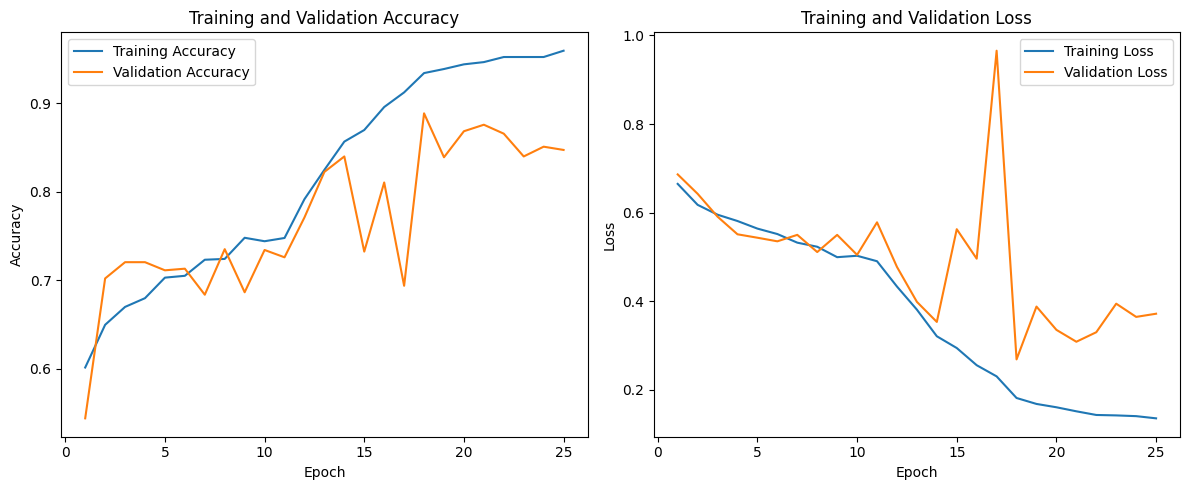

In [22]:
import matplotlib.pyplot as plt

# Combine histories from both training stages
combined_history = {}
for key in history1.history.keys():
    combined_history[key] = history1.history[key] + history2.history[key]

epochs = range(1, len(combined_history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, combined_history['accuracy'], label='Training Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, combined_history['loss'], label='Training Loss')
plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Save final best Keras model (.h5)
final_h5 = os.path.join(OUTPUT_DIR, "vgg16_binary_final.h5")
model.save(final_h5)
print("Saved final Keras model to:", final_h5)
print("File size (MB):", os.path.getsize(final_h5)/1e6)

Saved final Keras model to: /content/vgg_binary_output/vgg16_binary_final.h5
File size (MB): 178.581232


In [16]:
# Convert to SavedModel (TF) for compatibility
saved_model_dir = os.path.join(OUTPUT_DIR, "saved_model_vgg16_binary")
model.export(saved_model_dir, include_optimizer=False)
print("Saved SavedModel to:", saved_model_dir)

Saved artifact at '/content/vgg_binary_output/saved_model_vgg16_binary'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139840681501200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139840681502928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139840681503888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139840681502544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139840681502352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139840681504464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139840681505040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139840681505808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139840681506768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139840681504656: TensorSpec(shape=(), dtype=tf.re

In [17]:
# TFLite conversion (float16 quantization) - much smaller and deployable
tflite_fp16_path = os.path.join(OUTPUT_DIR, "vgg16_binary_fp16.tflite")
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# float16 quantization - good size reduction with minimal accuracy drop
converter.target_spec.supported_types = [tf.float16]
tflite_model_fp16 = converter.convert()
with open(tflite_fp16_path, "wb") as f:
    f.write(tflite_model_fp16)
print("Saved float16 TFLite model to:", tflite_fp16_path)
print("TFLite (float16) size (MB):", os.path.getsize(tflite_fp16_path)/1e6)

Saved float16 TFLite model to: /content/vgg_binary_output/vgg16_binary_fp16.tflite
TFLite (float16) size (MB): 30.099772


Found 1088 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step

===== Classification Report =====
              precision    recall  f1-score   support

    Demented       0.88      0.85      0.86       448
 NonDemented       0.90      0.92      0.91       640

    accuracy                           0.89      1088
   macro avg       0.89      0.88      0.88      1088
weighted avg       0.89      0.89      0.89      1088



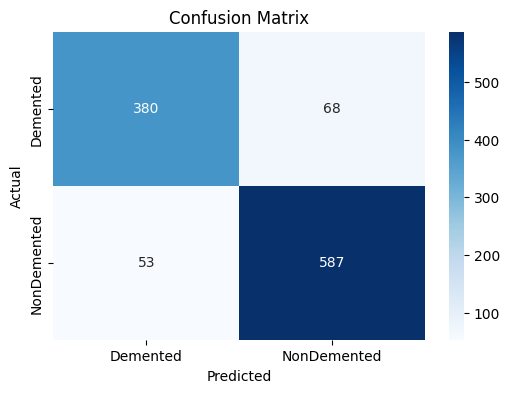


Overall Accuracy: 88.88%


In [21]:
# EVALUATE MODEL

# Load model
model = tf.keras.models.load_model("/content/vgg_binary_output/vgg16_binary_final.h5")

# Validation generator (same folder as training)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = "/content/Alzheimer_MRI_2_classes"   # change to your folder

val_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_gen = val_aug.flow_from_directory(
    DATA_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

# Get predictions
pred_probs = model.predict(val_gen)
pred_classes = (pred_probs > 0.5).astype("int32")

true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Classification Report
print("\n===== Classification Report =====")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"\nOverall Accuracy: {accuracy*100:.2f}%")


In [23]:
# -------------------------
# OPTIONAL: Full integer quantization (smaller) - requires representative dataset
# -------------------------
def representative_data_gen():
    # use a small number of samples from train_gen for representative dataset
    n = 100
    cnt = 0
    for imgs, _ in train_gen:
        for i in range(imgs.shape[0]):
            # imgs are already scaled 0-1; convert to float32
            yield [imgs[i].astype(np.float32)]
            cnt += 1
            if cnt >= n:
                return

tflite_int8_path = os.path.join(OUTPUT_DIR, "vgg16_binary_int8.tflite")
try:
    converter_int8 = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
    converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_int8.representative_dataset = representative_data_gen
    converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_int8.inference_input_type = tf.uint8   # or tf.int8
    converter_int8.inference_output_type = tf.uint8
    tflite_model_int8 = converter_int8.convert()
    with open(tflite_int8_path, "wb") as f:
        f.write(tflite_model_int8)
    print("Saved int8 TFLite model to:", tflite_int8_path)
    print("TFLite (int8) size (MB):", os.path.getsize(tflite_int8_path)/1e6)
except Exception as e:
    print("Integer quantization failed or not supported in this TF build:", str(e))

# -------------------------
# Quick evaluation of TFLite model (optional)
# -------------------------
def evaluate_tflite(tflite_file, dataset_gen, steps=50):
    import tensorflow as tf
    interpreter = tf.lite.Interpreter(model_path=tflite_file)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(dataset_gen):
        for j in range(imgs.shape[0]):
            img = imgs[j:j+1].astype(np.float32)
            # If model expects uint8 input (int8 quant), you must scale properly
            if input_details[0]['dtype'] == np.uint8:
                inp_scale, inp_zero = input_details[0]['quantization']
                img_q = (img / inp_scale + inp_zero).astype(np.uint8)
                interpreter.set_tensor(input_details[0]['index'], img_q)
            else:
                interpreter.set_tensor(input_details[0]['index'], img)
            interpreter.invoke()
            out = interpreter.get_tensor(output_details[0]['index'])
            # For binary, out may be single sigmoid value; threshold 0.5
            pred = 1 if out.flatten()[0] >= 0.5 else 0
            true = int(labels[j])
            if pred == true:
                correct += 1
            total += 1
        if total >= steps * imgs.shape[0]:
            break
    acc = correct / total
    return acc

# evaluate float16 if exists
if os.path.exists(tflite_fp16_path):
    print("Evaluating float16 TFLite (this uses validation generator):")
    # we need a fresh generator for evaluation - create one with shuffle=False
    eval_gen = valid_datagen.flow_from_directory(
        DATA_DIR, target_size=IMG_SIZE, batch_size=1, class_mode='binary', subset='validation', shuffle=False
    )
    acc_fp16 = evaluate_tflite(tflite_fp16_path, eval_gen, steps=100)
    print("Float16 TFLite approx accuracy:", acc_fp16)

print("All done. Output folder:", OUTPUT_DIR)


Integer quantization failed or not supported in this TF build: tensorflow/lite/kernels/conv.cc:345 input->dims->size != 4 (3 != 4)Node number 0 (CONV_2D) failed to prepare.
Evaluating float16 TFLite (this uses validation generator):
Found 1088 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Float16 TFLite approx accuracy: 0.8
All done. Output folder: /content/vgg_binary_output


In [24]:
import os

source_folder = "/content/vgg_binary_output"
destination_folder = "/content/drive/MyDrive/ML Project - Alzheimer Stage Prediction/vgg_binary_output"

# Remove existing folder if it exists
if os.path.exists(destination_folder):
    print(f"Removing existing folder: {destination_folder}")
    !rm -rf "{destination_folder}"

# Use the shell command `cp -r` to copy the directory recursively
print(f"Copying folder '{source_folder}' to '{destination_folder}'...")
!cp -r "{source_folder}" "{os.path.dirname(destination_folder)}"

print(f"Folder '{source_folder}' successfully copied to '{destination_folder}'.")

Copying folder '/content/vgg_binary_output' to '/content/drive/MyDrive/ML Project - Alzheimer Stage Prediction/vgg_binary_output'...
Folder '/content/vgg_binary_output' successfully copied to '/content/drive/MyDrive/ML Project - Alzheimer Stage Prediction/vgg_binary_output'.
